<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance (2nd ed.)

**Mastering Data-Driven Finance**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="http://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Statistics (b)

## Bayesian Regression

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%matplotlib inline

### Introductory Example

In [3]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2

In [4]:
reg = np.polyfit(x, y, 1)

In [5]:
reg

array([2.03384161, 3.77649234])

Text(0, 0.5, 'y')

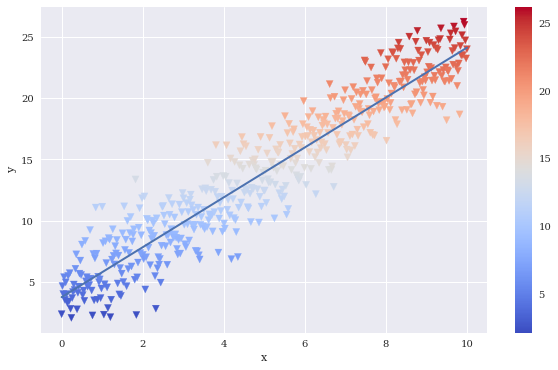

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
# plt.savefig('../../images/ch13/stat_15.png');

In [7]:
import warnings; warnings.simplefilter('ignore')

In [8]:
import pymc3 as pm

In [9]:
%%time
with pm.Model() as model:
    # model
    alpha = pm.Normal('alpha', mu=0, sd=20)  
    beta = pm.Normal('beta', mu=0, sd=10)  
    sigma = pm.Uniform('sigma', lower=0, upper=10)  
    y_est = alpha + beta * x  
    likelihood = pm.Normal('y', mu=y_est, sd=sigma,
                           observed=y)  
    
    # inference
    start = pm.find_MAP()  
    step = pm.NUTS()  
    trace = pm.sample(100, tune=1000, start=start,
                      progressbar=True, verbose=False)  

logp = -1,067.8, ||grad|| = 60.354: 100%|██████████| 28/28 [00:00<00:00, 1414.72it/s]  
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 4400/4400 [00:02<00:00, 2082.68draws/s]

CPU times: user 5.41 s, sys: 1.41 s, total: 6.81 s
Wall time: 1min 12s


In [10]:
pm.summary(trace)  

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,3.766462,0.169574,0.010178,3.415895,4.066964,242.466271,1.010573
beta,2.035621,0.028850,0.001752,1.978759,2.088702,223.564156,1.003848
sigma,2.003567,0.058596,0.003146,1.892570,2.124499,296.917994,1.002454


In [11]:
trace[0]  

{'alpha': 4.058315495397339,
 'beta': 1.9734526083756765,
 'sigma_interval__': -1.4176735028146576,
 'sigma': 1.9502656405883532}

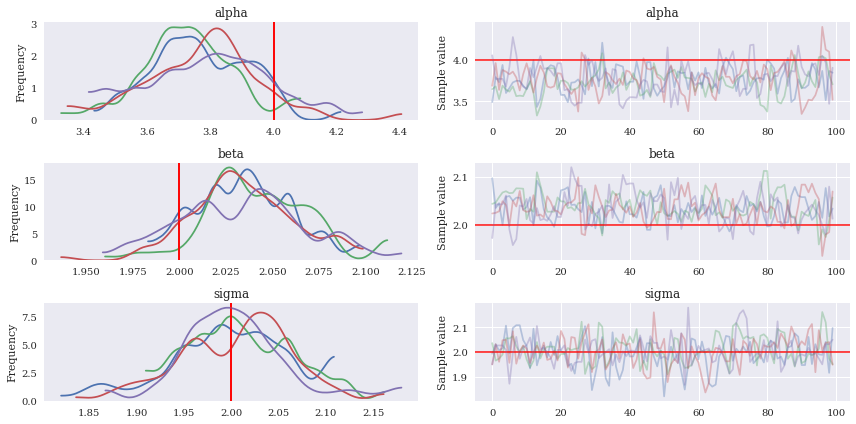

In [12]:
pm.traceplot(trace, lines={'alpha': 4, 'beta': 2, 'sigma': 2});  
# plt.savefig('../../images/ch13/stat_16.png');

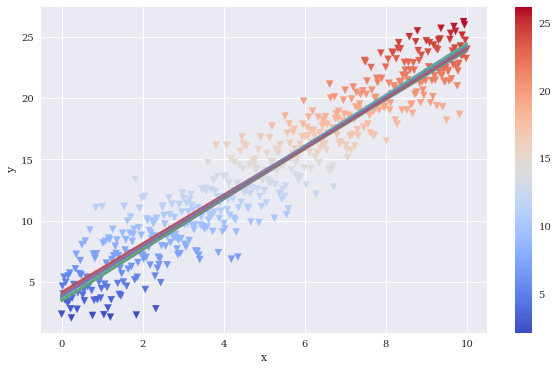

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x)  
# plt.savefig('../../images/ch13/stat_17.png');

### Two Financial Instruments

In [14]:
raw = pd.read_csv('../../source/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [15]:
data = raw[['GDX', 'GLD']].dropna()

In [16]:
data = data / data.iloc[0]  

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 2 columns):
GDX    2138 non-null float64
GLD    2138 non-null float64
dtypes: float64(2)
memory usage: 50.1 KB


In [18]:
data.ix[-1] / data.ix[0] - 1  

GDX   -0.532383
GLD    0.080601
dtype: float64

In [19]:
data.corr()  

,GDX,GLD
GDX,1.00000,0.71539
GLD,0.71539,1.00000


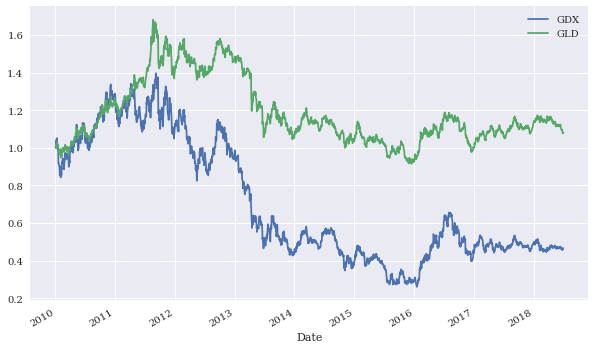

In [20]:
data.plot(figsize=(10, 6));
# plt.savefig('../../images/ch13/stat_18.png');

In [21]:
data.index[:3]

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06'], dtype='datetime64[ns]', name='Date', freq=None)

In [22]:
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())  
mpl_dates[:3]

array([733776., 733777., 733778.])

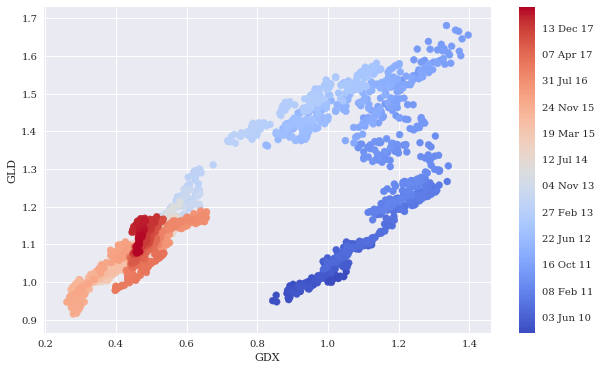

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
            marker='o', cmap='coolwarm')
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'));  
# plt.savefig('../../images/ch13/stat_19.png');

In [24]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    y_est = alpha + beta * data['GDX'].values
    
    likelihood = pm.Normal('GLD', mu=y_est, sd=sigma,
                           observed=data['GLD'].values)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(250, tune=2000, start=start,
                      progressbar=True)

logp = 1,493.7, ||grad|| = 188.29: 100%|██████████| 27/27 [00:00<00:00, 1928.05it/s]   
Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 9000/9000 [00:05<00:00, 1582.12draws/s]


In [25]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.913716,0.006372,0.000302,0.901528,0.925733,382.746875,0.999778
beta,0.385289,0.008201,0.000386,0.369987,0.401430,385.563232,0.999728
sigma,0.119566,0.001731,0.000066,0.116063,0.122679,700.608333,0.999938


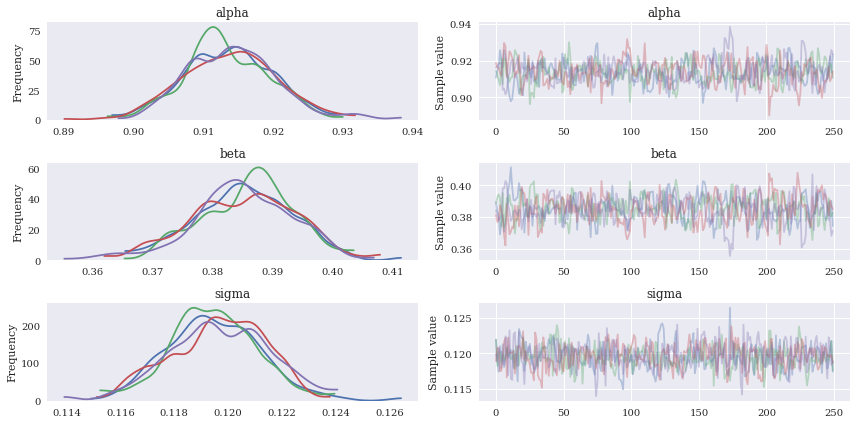

In [26]:
fig = pm.traceplot(trace)
# plt.savefig('../../images/ch13/stat_20.png');

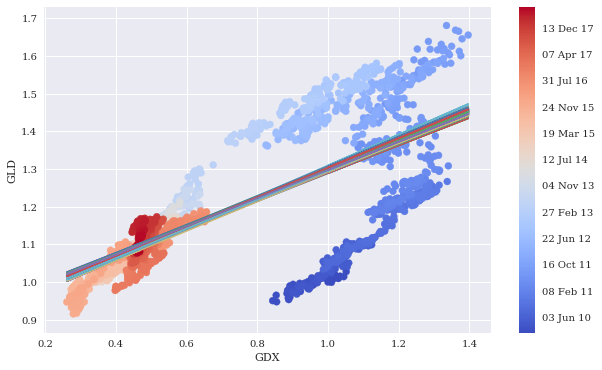

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
            marker='o', cmap='coolwarm')
plt.xlabel('GDX')
plt.ylabel('GLD')
for i in range(len(trace)):
    plt.plot(data['GDX'], trace['alpha'][i] + trace['beta'][i] * data['GDX'])
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'));
# plt.savefig('../../images/ch13/stat_21.png');

In [28]:
from pymc3.distributions.timeseries import GaussianRandomWalk

In [29]:
subsample_alpha = 50
subsample_beta = 50

In [30]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sig_alpha', 1. / .02, testval=.1)  
    sigma_beta = pm.Exponential('sig_beta', 1. / .02, testval=.1)  
    alpha = GaussianRandomWalk('alpha', sigma_alpha ** -2,
                        shape=int(len(data) / subsample_alpha))  
    beta = GaussianRandomWalk('beta', sigma_beta ** -2,
                        shape=int(len(data) / subsample_beta))  
    alpha_r = np.repeat(alpha, subsample_alpha)  
    beta_r = np.repeat(beta, subsample_beta)  
    regression = alpha_r + beta_r * data['GDX'].values[:2100]  
    sd = pm.Uniform('sd', 0, 20)  
    likelihood = pm.Normal('GLD', mu=regression, sd=sd,
                           observed=data['GLD'].values[:2100])  

In [31]:
%%time
import scipy.optimize as sco
with model_randomwalk:
    start = pm.find_MAP(vars=[alpha, beta],
                        fmin=sco.fmin_l_bfgs_b)
    step = pm.NUTS(scaling=start)
    trace_rw = pm.sample(250, tune=1000, start=start,
                         progressbar=True)

logp = -6,657:   2%|▏         | 82/5000 [00:00<00:04, 994.94it/s]   
Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, alpha, sig_beta, sig_alpha]
Sampling 4 chains: 100%|██████████| 5000/5000 [01:40<00:00, 49.54draws/s]


CPU times: user 21 s, sys: 2.56 s, total: 23.5 s
Wall time: 2min 58s


In [32]:
pm.summary(trace_rw).head()  

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,0.671122,0.041196,0.000923,0.589880,0.752113,1739.391051,0.998317
alpha__1,0.423104,0.040522,0.000954,0.349619,0.508980,1865.007805,0.998481
alpha__2,0.456570,0.058772,0.001517,0.345986,0.566016,1796.178804,0.998320
alpha__3,0.270409,0.043852,0.001101,0.180468,0.348465,1734.496112,0.998244
alpha__4,0.651374,0.058547,0.001281,0.532699,0.765912,2548.887035,0.999824


In [33]:
sh = np.shape(trace_rw['alpha'])  
sh  

(1000, 42)

In [34]:
part_dates = np.linspace(min(mpl_dates),
                         max(mpl_dates), sh[1])  

In [35]:
index = [dt.datetime.fromordinal(int(date)) for
        date in part_dates]  

In [36]:
alpha = {'alpha_%i' % i: v for i, v in
         enumerate(trace_rw['alpha']) if i < 20}  

In [37]:
beta = {'beta_%i' % i: v for i, v in
         enumerate(trace_rw['beta']) if i < 20}  

In [38]:
df_alpha = pd.DataFrame(alpha, index=index)  

In [39]:
df_beta = pd.DataFrame(beta, index=index)  

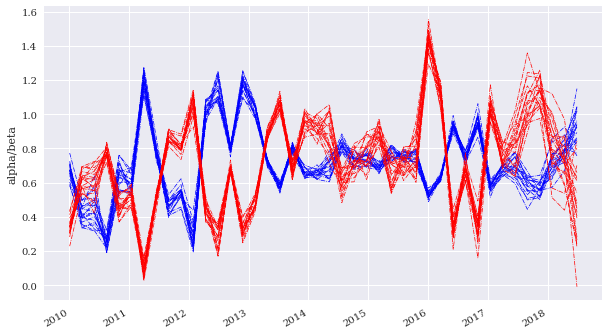

In [40]:
ax = df_alpha.plot(color='b', style='-.', legend=False,
                   lw=0.7, figsize=(10, 6))
df_beta.plot(color='r', style='-.', legend=False,
             lw=0.7, ax=ax)
plt.ylabel('alpha/beta');
# plt.savefig('../../images/ch13/stat_22.png');

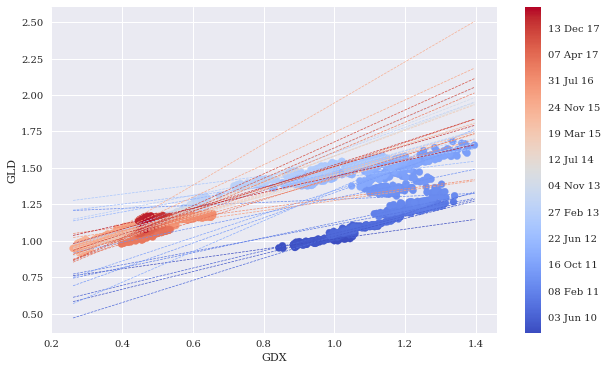

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
            marker='o', cmap='coolwarm')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'))
plt.xlabel('GDX')
plt.ylabel('GLD')
x = np.linspace(min(data['GDX']), max(data['GDX']))
for i in range(sh[1]):  
    alpha_rw = np.mean(trace_rw['alpha'].T[i])
    beta_rw = np.mean(trace_rw['beta'].T[i])
    plt.plot(x, alpha_rw + beta_rw * x, '--', lw=0.7,
            color=plt.cm.coolwarm(i / sh[1]))
# plt.savefig('../../images/ch13/stat_23.png');

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>